In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader
from copy import deepcopy as dc
import mlflow
import mlflow.pytorch
mlflow.create_experiment("With autologging LSTM_BDL3")
mlflow.set_experiment("With autologging LSTM_BDL3")

D:\cda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Experiment: artifact_location='file:///C:/Users/91979/Desktop/Jup_NoteBks/BDL/FinalProject_BDL/mlruns/281710725616056853', creation_time=1716141351270, experiment_id='281710725616056853', last_update_time=1716141351270, lifecycle_stage='active', name='With autologging LSTM_BDL3', tags={}>

In [3]:
mlflow.autolog()
mlflow.pytorch.autolog()

2024/05/19 23:27:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [4]:
def read_data(path):
    data = pd.read_csv(path)
    return data
def extract_T(data):
    data_T = data[['datetime', 'temp']]
    data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')
    return data_T
#Now to put in format easily readable by pytorch for lstm
def prep_df_lstm(df, n_steps):
    df = dc(df)
    df.set_index('datetime', inplace=True)
    for i in range(1, n_steps + 1):
        df['t-' + str(i)] = df['temp'].shift(i)
    df.dropna(inplace=True)
    return df
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def convertscale(data):
    data_np=data.to_numpy()
    scaler=MinMaxScaler()
    data_scaled=scaler.fit_transform(data_np)
    return data_scaled,scaler
def prep_data(data,n_steps):
    #Split into X, y here
    X=data[:,1:]
    y=data[:,0]
    X=dc(np.flip(X,axis=1))
    return X,y
def split_data(X,y,split_index_1,split_index_2):
    X_train=X[:split_index_1]
    y_train=y[:split_index_1]
    X_test=X[split_index_1:split_index_2]
    y_test=y[split_index_1:split_index_2]
    X_val=X[split_index_2:]
    y_val=y[split_index_2:]
    return X_train,y_train,X_test,y_test,X_val,y_val
def reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,time_period,device): #Here time period is number of days used for predictions in the shifted data
    X_train=X_train.reshape(-1,time_period,1) #Requirement for LSTM in pytorch
    X_test=X_test.reshape(-1,time_period,1)
    y_train=y_train.reshape(-1,1)
    y_test=y_test.reshape(-1,1)
    X_val=X_val.reshape(-1,time_period,1)
    y_val=y_val.reshape(-1,1)
    X_train=torch.tensor(X_train).float().to(device)
    y_train=torch.tensor(y_train).float().to(device)
    X_test=torch.tensor(X_test).float().to(device)
    y_test=torch.tensor(y_test).float().to(device)
    X_val=torch.tensor(X_val).float().to(device)
    y_val=torch.tensor(y_val).float().to(device)
    return X_train,y_train,X_test,y_test,X_val,y_val

In [12]:
class WeatherDataset(Dataset):
    def __init__(self,X,y):
        self.X=X
        self.y=y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
def data_load(X_train,y_train,X_test,y_test,X_val,y_val,batch_size):
    train_dataset=WeatherDataset(X_train,y_train)
    test_dataset=WeatherDataset(X_test,y_test)
    #val_dataset=WeatherDataset(X_val,y_val)
    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)
    #val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
    return train_loader,test_loader
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,output_size)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        out,_=self.lstm(x,(h0,c0))
        out=self.fc(out[:,-1,:])
        return out
    
def train_epoch(epoch, model, train_loader, criterion, optimizer, loss_train):
    model.train(True)
    print(f'Epoch {epoch+1}')
    running_loss = 0
    for batch_index, batch in enumerate(train_loader):
        X_batch, y_batch = batch
        output = model(X_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_index % 100 == 99:
            avg_loss = running_loss / 100
            print(f'Batch: {batch_index + 1} Loss: {avg_loss}')
            loss_train.append(avg_loss)
            plt.plot(loss_train)
            plt.show()
            running_loss = 0

def validate_epoch(model, test_loader, criterion):
    model.train(False)
    running_loss = 0
    for batch_index, batch in enumerate(test_loader):
        X_batch, y_batch = batch
        with torch.no_grad():
            output = model(X_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()
    avg_loss = running_loss / len(test_loader)
    print(f'Validation Loss: {avg_loss}')
    return avg_loss

def train_model(lr, num_epochs, criterion, optimizer, scheduler, model, train_loader, test_loader):
    loss_train = []
    for epoch in range(num_epochs):
        train_epoch(epoch, model, train_loader, criterion, optimizer, loss_train)
        val_loss = validate_epoch(model, test_loader, criterion)
        scheduler.step()
        mlflow.log_metric("Validation Loss", val_loss, step=epoch)

def prediction(model,X_input,y_input,time_period,scaler):
    with torch.no_grad():
        predicted=model(X_input).to('cpu').numpy()
    train_predictions=predicted.flatten()
    dummies=np.zeros((X_input.to('cpu').shape[0],time_period+1))
    dummies[:,0]=train_predictions
    dummies=scaler.inverse_transform(dummies)
    train_predictions=dc(dummies[:,0])
    dummies=np.zeros((X_input.to('cpu').shape[0],time_period+1))
    dummies[:,0]=y_input.to('cpu').numpy().flatten()
    dummies=scaler.inverse_transform(dummies)
    new_y_train=dc(dummies[:,0]) 
    return train_predictions,new_y_train
def plot_predictions(train_predictions,new_y_train):
    plt.plot(new_y_train,label='Actual')
    plt.plot(train_predictions,label='Predicted')
    plt.legend()
    plt.show()
def mean_error(train_predictions,new_y_train):
    error=np.mean(np.abs(train_predictions-new_y_train))
    print(f'Mean Error : {error}')
    return error

Experiment 1:

2024/05/19 23:57:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
C:\Users\91979\AppData\Local\Temp\ipykernel_30160\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss: 0.04124732563893
Epoch 2
Validation Loss: 0.0053899236566697555
Epoch 3
Validation Loss: 0.027823317795991898
Epoch 4
Validation Loss: 0.008864796720445156
Epoch 5
Validation Loss: 0.007718267850577831
Epoch 6
Validation Loss: 0.0110031987229983
Epoch 7
Validation Loss: 0.005222876866658528
Epoch 8
Validation Loss: 0.006835573042432467
Epoch 9
Validation Loss: 0.006248697948952516
Epoch 10
Validation Loss: 0.005251767113804817


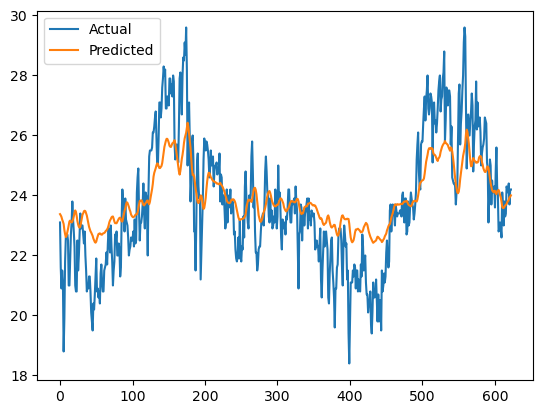

Mean Error : 1.1159698567196228


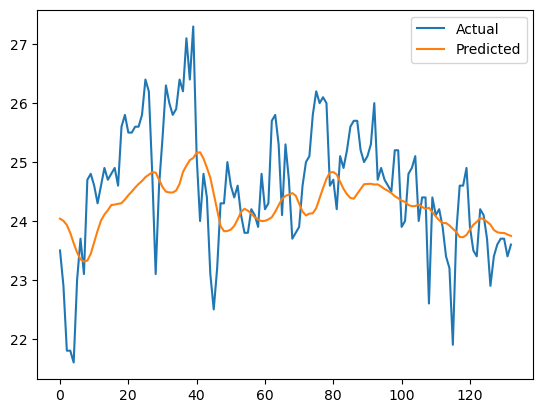

Mean Error : 0.7771271121681184


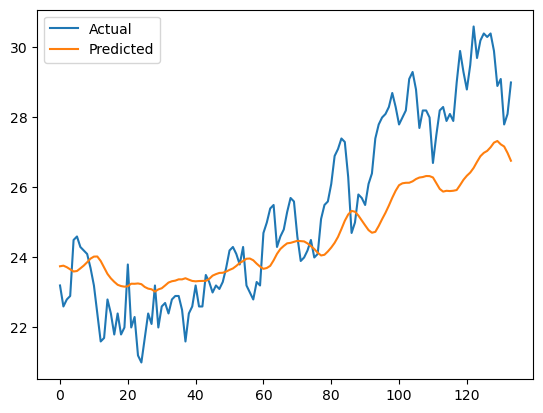

Mean Error : 1.3583374044121204
1.3583374044121204


In [14]:
with mlflow.start_run(run_name="Model 1"):   
    mlflow.autolog()
    data=read_data(r"C:\Users\91979\Desktop\Jup_NoteBks\BDL\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.001
    epochs=10
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.7*len(X))
    split_index_2=int(0.85*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,64,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    print(error)
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model2.pth")
    # mlflow.pytorch.log_model(model, "model")

Experiment 2


2024/05/19 23:58:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
C:\Users\91979\AppData\Local\Temp\ipykernel_30160\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss: 0.03509223026533922
Epoch 2
Validation Loss: 0.007288923487067223
Epoch 3
Validation Loss: 0.02200835384428501
Epoch 4
Validation Loss: 0.011051026949038109
Epoch 5
Validation Loss: 0.00935679596538345
Epoch 6
Validation Loss: 0.006737652778004606
Epoch 7
Validation Loss: 0.008495173106590906
Epoch 8
Validation Loss: 0.006686079471061627
Epoch 9
Validation Loss: 0.0059176368328432245
Epoch 10
Validation Loss: 0.009434944794823727


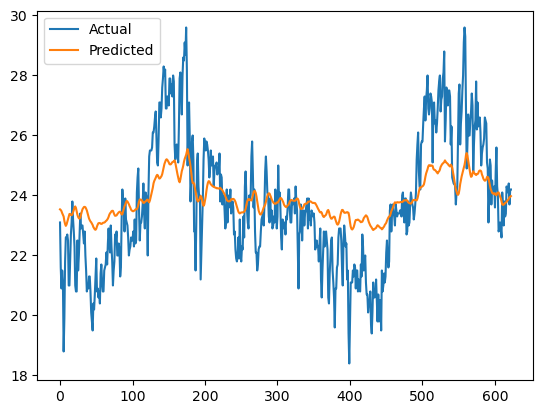

Mean Error : 1.2984267683630966


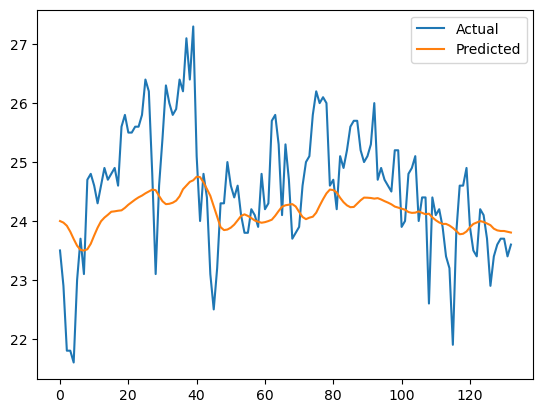

Mean Error : 0.8341243756444829


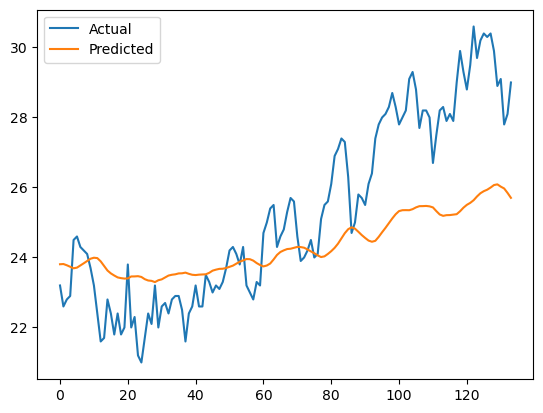

Mean Error : 1.6699384341711434
1.6699384341711434


In [15]:
with mlflow.start_run(run_name="Model 2"):
    mlflow.autolog()
    data=read_data(r"C:\Users\91979\Desktop\Jup_NoteBks\BDL\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.001
    epochs=10
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.7*len(X))
    split_index_2=int(0.85*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,64,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
# #Save model

    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model3ml.pth")
#     mlflow.pytorch.log_model(model, "model")

Experiment 3

2024/05/19 23:58:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
C:\Users\91979\AppData\Local\Temp\ipykernel_30160\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss: 0.015149112480382124
Epoch 2
Validation Loss: 0.029504376153151195
Epoch 3
Validation Loss: 0.006274720498671134
Epoch 4
Validation Loss: 0.015673895676930744
Epoch 5
Validation Loss: 0.006867049882809321
Epoch 6
Validation Loss: 0.009294561420877775
Epoch 7
Validation Loss: 0.009706321793297926
Epoch 8
Validation Loss: 0.008282454529156288
Epoch 9
Validation Loss: 0.00500244798604399
Epoch 10
Validation Loss: 0.005945333978161216
Epoch 11
Validation Loss: 0.005669751825431983
Epoch 12
Validation Loss: 0.00580149640639623
Epoch 13
Validation Loss: 0.005432597904776533
Epoch 14
Validation Loss: 0.0053407732242097454
Epoch 15
Validation Loss: 0.006462321461488803
Epoch 16
Validation Loss: 0.005293049694349368
Epoch 17
Validation Loss: 0.004947058429631094
Epoch 18
Validation Loss: 0.0056349037525554495
Epoch 19
Validation Loss: 0.008247075912853083
Epoch 20
Validation Loss: 0.007814606962104639
Epoch 21
Validation Loss: 0.009701919586708149
Epoch 22
Validation Lo

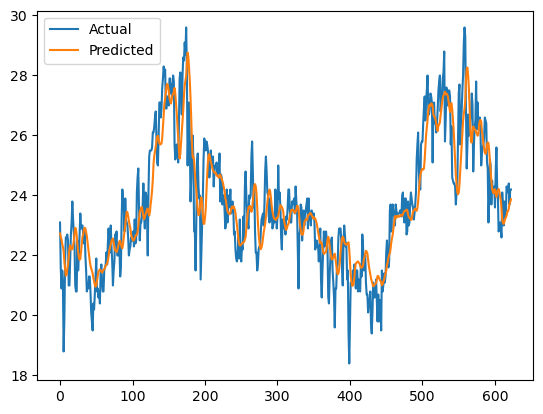

Mean Error : 0.8081633822230047


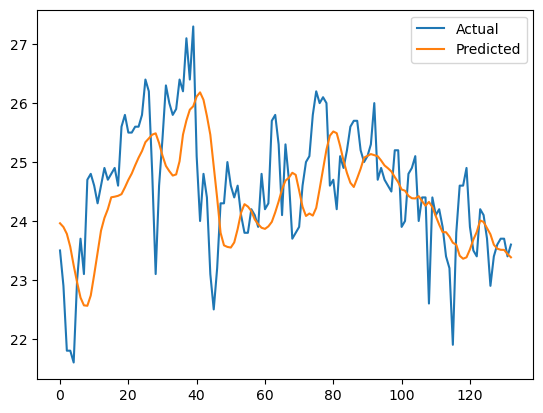

Mean Error : 0.7767607299456918


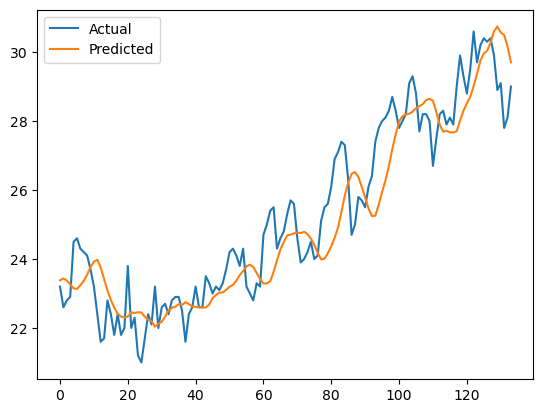

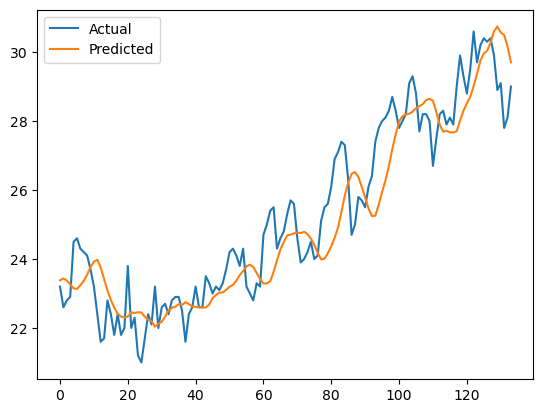

Mean Error : 0.8110980943734967
0.8110980943734967


In [16]:
with mlflow.start_run(run_name="Model 3"):
    mlflow.autolog()
    data=read_data(r"C:\Users\91979\Desktop\Jup_NoteBks\BDL\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.001
    epochs=50
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.7*len(X))
    split_index_2=int(0.85*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,128,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
#Save model
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model4ml.pth")
    # mlflow.pytorch.log_model(model, "model")

Experiment 4

2024/05/20 00:01:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
C:\Users\91979\AppData\Local\Temp\ipykernel_30160\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss: 0.006231267315646012
Epoch 2
Validation Loss: 0.00494013074785471
Epoch 3
Validation Loss: 0.0089192984936138
Epoch 4
Validation Loss: 0.005990244137744109
Epoch 5
Validation Loss: 0.007427106456210216
Epoch 6
Validation Loss: 0.014235771882037321
Epoch 7
Validation Loss: 0.005825805788238843
Epoch 8
Validation Loss: 0.004267417282486956
Epoch 9
Validation Loss: 0.004952308877060811
Epoch 10
Validation Loss: 0.00595996839304765
Epoch 11
Validation Loss: 0.005200060550123453
Epoch 12
Validation Loss: 0.005699041609962781
Epoch 13
Validation Loss: 0.004563802853226662
Epoch 14
Validation Loss: 0.005369442204634349
Epoch 15
Validation Loss: 0.005074742250144482
Epoch 16
Validation Loss: 0.0056305381779869395
Epoch 17
Validation Loss: 0.007477682549506426
Epoch 18
Validation Loss: 0.005795620537052552
Epoch 19
Validation Loss: 0.005519090220332146
Epoch 20
Validation Loss: 0.004210391663946211
Epoch 21
Validation Loss: 0.0044168950989842415
Epoch 22
Validation Loss

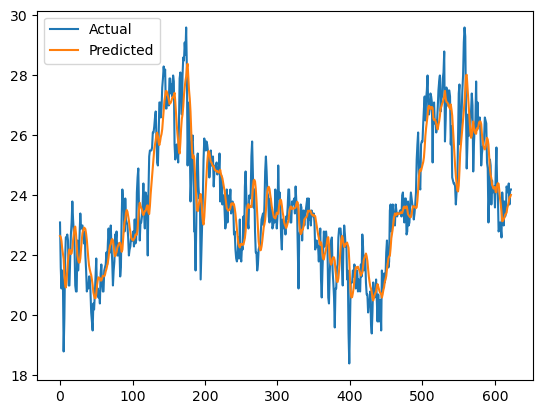

Mean Error : 0.738178536551818


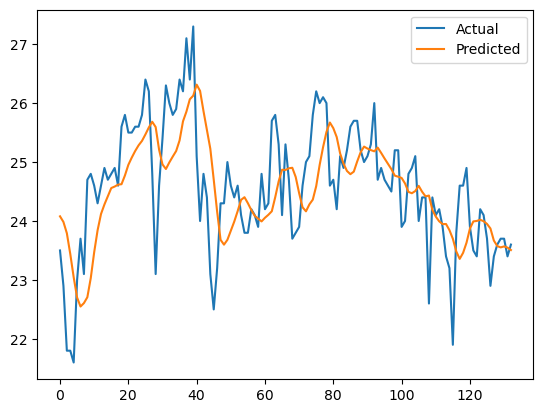

Mean Error : 0.7036188787535617


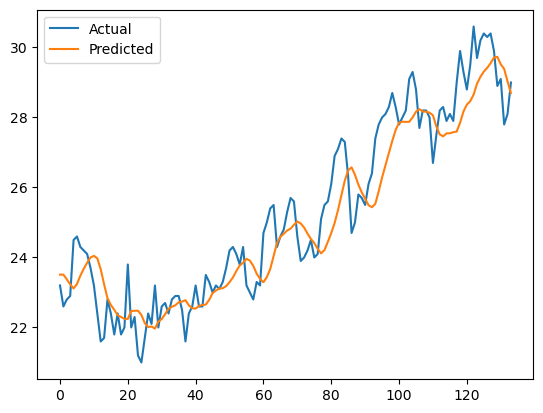

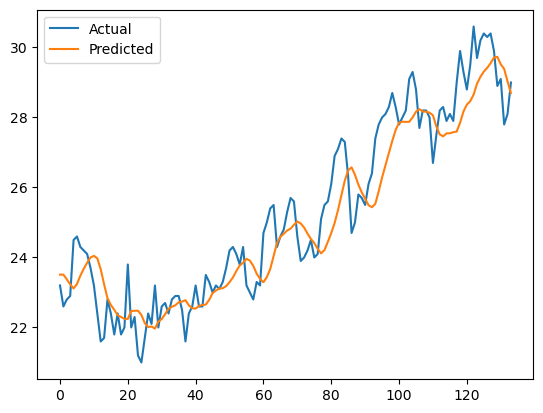

Mean Error : 0.7332466771575943
0.7332466771575943


In [17]:
with mlflow.start_run(run_name="Model 4"):
    mlflow.autolog()
    data=read_data(r"C:\Users\91979\Desktop\Jup_NoteBks\BDL\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.005
    epochs=100
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.7*len(X))
    split_index_2=int(0.85*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,128,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
#Save model
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model5ml.pth")
    # mlflow.pytorch.log_model(model, "model")

Experiment 5

2024/05/20 00:08:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
C:\Users\91979\AppData\Local\Temp\ipykernel_30160\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss: 0.01448547001928091
Epoch 2
Validation Loss: 0.009784805588424206
Epoch 3
Validation Loss: 0.009349154308438301
Epoch 4
Validation Loss: 0.00982689205557108
Epoch 5
Validation Loss: 0.007613735273480415
Epoch 6
Validation Loss: 0.0071660843677818775
Epoch 7
Validation Loss: 0.0050562601536512375
Epoch 8
Validation Loss: 0.006094872485846281
Epoch 9
Validation Loss: 0.005397557746618986
Epoch 10
Validation Loss: 0.004910783376544714
Epoch 11
Validation Loss: 0.005184303969144821
Epoch 12
Validation Loss: 0.00581014109775424
Epoch 13
Validation Loss: 0.005079308524727821
Epoch 14
Validation Loss: 0.004802066367119551
Epoch 15
Validation Loss: 0.004924038425087929
Epoch 16
Validation Loss: 0.005154265556484461
Epoch 17
Validation Loss: 0.005009525455534458
Epoch 18
Validation Loss: 0.0050130258314311504
Epoch 19
Validation Loss: 0.005028011742979288
Epoch 20
Validation Loss: 0.005005196202546358
Epoch 21
Validation Loss: 0.004962868522852659
Epoch 22
Validation Lo

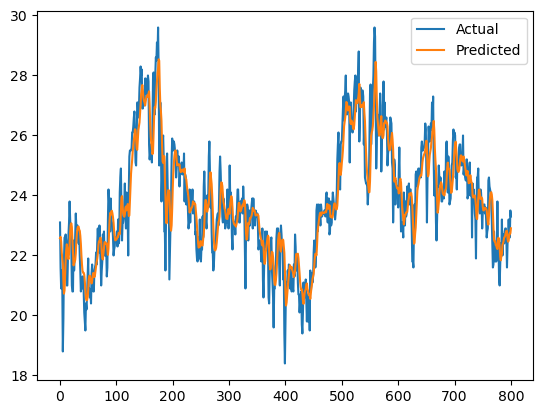

Mean Error : 0.678640029892865


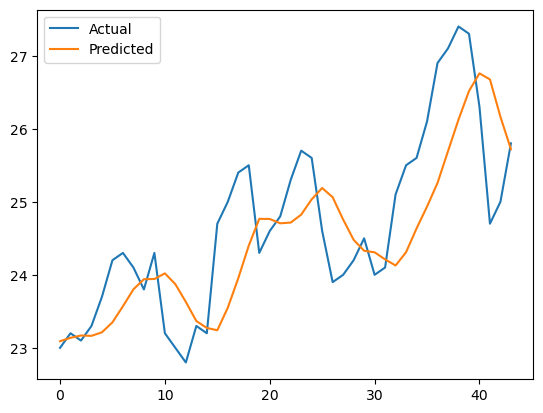

Mean Error : 0.6942532468925826


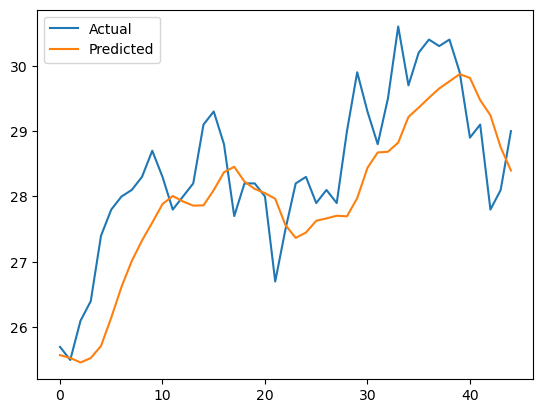

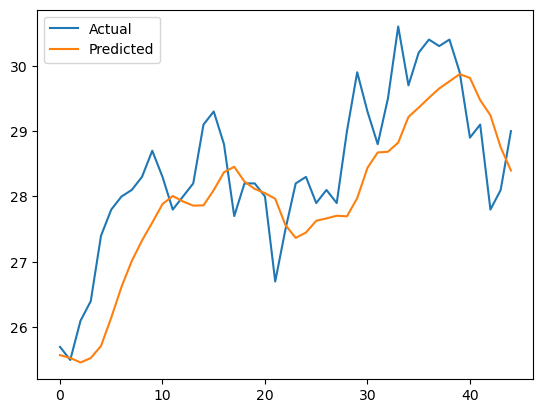

Mean Error : 0.7245266890525822
0.7245266890525822


In [18]:
with mlflow.start_run(run_name="Model 5"):
    mlflow.autolog()
    data=read_data(r"C:\Users\91979\Desktop\Jup_NoteBks\BDL\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.005
    epochs=100
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.9*len(X))
    split_index_2=int(0.95*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,128,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
#Save model
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model6ml.pth")
    # mlflow.pytorch.log_model(model, "model")

Experiment 6


2024/05/20 00:16:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
C:\Users\91979\AppData\Local\Temp\ipykernel_30160\1020498080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T['datetime'] = pd.to_datetime(data_T['datetime'], format='%Y-%m-%d')


Epoch 1
Validation Loss: 0.013931024819612503
Epoch 2
Validation Loss: 0.007983945310115814
Epoch 3
Validation Loss: 0.007810451555997133
Epoch 4
Validation Loss: 0.018477214500308037
Epoch 5
Validation Loss: 0.006754313595592976
Epoch 6
Validation Loss: 0.007736723404377699
Epoch 7
Validation Loss: 0.006096853408962488
Epoch 8
Validation Loss: 0.0077171954326331615
Epoch 9
Validation Loss: 0.006388157606124878
Epoch 10
Validation Loss: 0.007196240592747927
Epoch 11
Validation Loss: 0.007109211757779121
Epoch 12
Validation Loss: 0.006595083978027105
Epoch 13
Validation Loss: 0.007073375396430492
Epoch 14
Validation Loss: 0.006848825141787529
Epoch 15
Validation Loss: 0.006824557203799486
Epoch 16
Validation Loss: 0.006829965393990278
Epoch 17
Validation Loss: 0.0067217350006103516
Epoch 18
Validation Loss: 0.006743146572262049
Epoch 19
Validation Loss: 0.00671530794352293
Epoch 20
Validation Loss: 0.006785136181861162
Epoch 21
Validation Loss: 0.006749678868800402
Epoch 22
Validation L

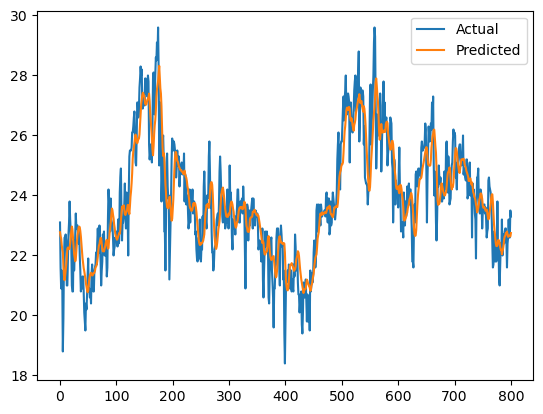

Mean Error : 0.7545285072498554


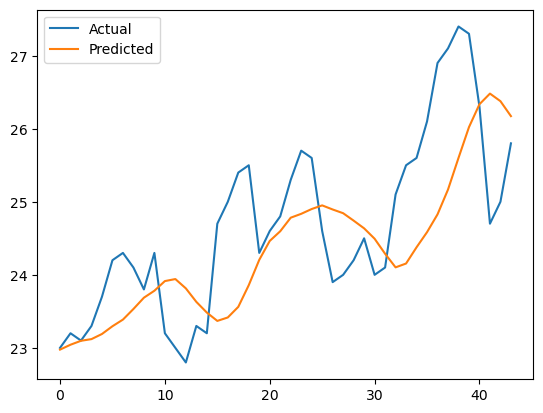

Mean Error : 0.8037595991383899


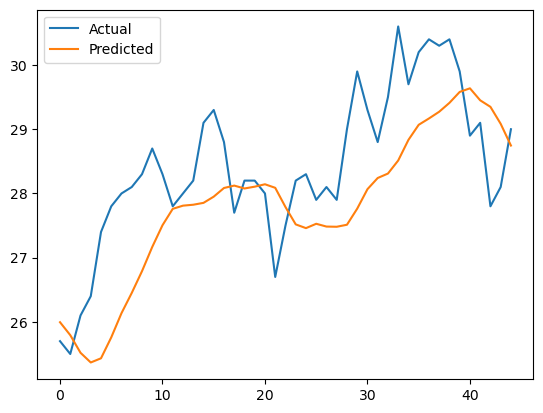

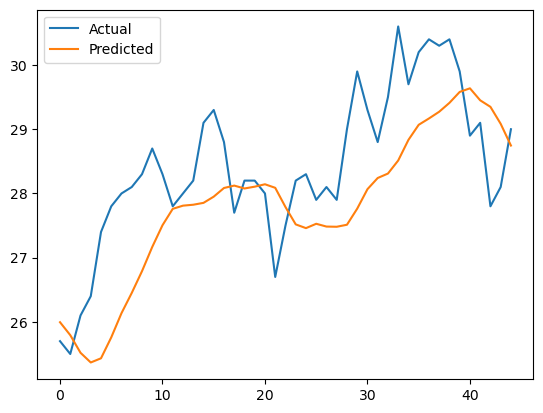

Mean Error : 0.9110605931282044
0.9110605931282044


In [20]:
with mlflow.start_run(run_name="Model 6"):
    mlflow.autolog()
    data=read_data(r"C:\Users\91979\Desktop\Jup_NoteBks\BDL\FinalProject_BDL\Bangalore,India 2021-10-30 to 2024-04-13.csv")
    learning_rate=0.005
    epochs=30
    data_T=extract_T(data)
    data_T=prep_df_lstm(data_T,7)
    data_scaled,scaler=convertscale(data_T)
    X,y=prep_data(data_scaled,7)
    split_index_1=int(0.9*len(X))
    split_index_2=int(0.95*len(X))
    X_train,y_train,X_test,y_test,X_val,y_val=split_data(X,y,split_index_1,split_index_2)
    X_train,y_train,X_test,y_test,X_val,y_val=reshape_data_tensor(X_train,y_train,X_test,y_test,X_val,y_val,7,device)
    train_loader,test_loader=data_load(X_train,y_train,X_test,y_test,X_val,y_val,64)
    model=LSTM(1,256,2,1).to(device)
    criterion=nn.MSELoss()
    optimizer=optim.Adam(model.parameters(),lr=learning_rate)
    scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)
    train_model(learning_rate,epochs,criterion,optimizer,scheduler,model,train_loader,test_loader)
    train_predictions,new_y_train=prediction(model,X_train,y_train,7,scaler)
    plot_predictions(train_predictions,new_y_train)
    mean_error(train_predictions,new_y_train)
    test_predictions,new_y_test=prediction(model,X_test,y_test,7,scaler)
    plot_predictions(test_predictions,new_y_test)
    mean_error(test_predictions,new_y_test)
    val_predictions,new_y_val=prediction(model,X_val,y_val,7,scaler)
    plot_predictions(val_predictions,new_y_val)
    plot_predictions(val_predictions,new_y_val)
    error=mean_error(val_predictions,new_y_val)
#Save model
    print(error)
    mlflow.log_metric("Error",error)
    mlflow.log_param("Learning rate",learning_rate)
    mlflow.log_param("Epoch count",epochs)
#Save model
    torch.save(model.state_dict(), "C:\\Users\\sriva\\OneDrive\\Documents\\GitHub\\FinalProject_BDL\model7ml.pth")
    # mlflow.pytorch.log_model(model, "model")